# Momentum vs Value Factor Performance Analysis (2024)
## Statistical Study of Indian Stock Market Returns

### Course Mapping:
- **Lectures 1-9:** Data types, organization, visualization, interpretation
- **Lectures 10-18:** Probability & distributions
- **Lectures 19-28:** Sampling, estimation, hypothesis testing

### Time Allocation: 3 Hours Total

## Story 1.1: Project Setup and Data Loading (15 mins)

In [2]:
!pip install pandas numpy matplotlib seaborn scipy

In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style and random seed for reproducibility
sns.set_style('whitegrid')
np.random.seed(42)

print("Libraries imported successfully!")
print("Working Directory:", pd.os.getcwd() if hasattr(pd, 'os') else 'Check manually')

Libraries imported successfully!
Working Directory: Check manually


### Load the Datasets
1. Stock Price Data (2015-2024)
2. Fundamental Ratios

In [4]:
# Load price data
price_data = pd.read_csv('Datasets/stock_price_dataset/Stock_Data.csv', index_col=0)
print(f"Price data shape: {price_data.shape}")
print(f"Columns: {price_data.columns.tolist()}")
print(f"\nFirst few rows:")
print(price_data.head())
print(f"\nDate range: {price_data['Date'].min()} to {price_data['Date'].max()}")

Price data shape: (453672, 6)
Columns: ['Date', 'Stock', 'Index_name', 'Close', 'Volume', 'Daily_Return_%']

First few rows:
         Date       Stock Index_name    Close   Volume  Daily_Return_%
0  2015-01-01  ADANIPORTS   NIFTY 50   303.24  1456204            0.17
1  2015-01-01  APOLLOHOSP   NIFTY 50  1083.59    76848           -0.45
2  2015-01-01  ASIANPAINT   NIFTY 50   695.76   284935           -0.26
3  2015-01-01    AXISBANK   NIFTY 50   486.87  1351985            0.08
4  2015-01-01  BAJFINANCE   NIFTY 50   339.66    75660            0.45

Date range: 2015-01-01 to 2024-12-30


In [5]:
# Load fundamentals data
fundamentals = pd.read_csv('Datasets/FUNDAMENTALratios.csv')
print(f"Fundamentals shape: {fundamentals.shape}")
print(f"Columns: {fundamentals.columns.tolist()}")
print(f"\nFirst few rows:")
print(fundamentals.head())
print(f"\nUnique stocks in fundamentals: {fundamentals['symbol'].nunique()}")

Fundamentals shape: (5910, 18)
Columns: ['symbol', 'revenuePerShare', 'trailingPE', 'earningsQuarterlyGrowth', 'previousClose', 'open', 'dayLow', 'dayHigh', 'volume', 'trailingEps', 'pegRatio', 'ebitda', 'totalDebt', 'totalRevenue', 'debtToEquity', 'revenuePerShare.1', 'earningsGrowth', 'revenueGrowth']

First few rows:
          symbol  revenuePerShare  trailingPE  earningsQuarterlyGrowth  \
0    RELIANCE.BO         1296.823   28.012129                    0.093   
1    RELIANCE.NS         1296.823   28.010878                    0.093   
2    HDFCBANK.BO          293.740   16.260424                    0.359   
3  HINDUNILVR.NS          263.412   51.285230                    0.014   
4   ICICIBANK.NS          197.399   18.315136                    0.257   

   previousClose     open   dayLow  dayHigh      volume  trailingEps  \
0        2901.30  2897.05  2895.35   2920.0    562484.0       103.88   
1        2901.95  2899.95  2894.70   2920.0   9763420.0       103.89   
2        1445.10 

## Story 1.2: Data Cleaning and Integration (20 mins)
Filter to 2023-2024 period and merge datasets

In [6]:
# Convert date column to datetime
price_data['Date'] = pd.to_datetime(price_data['Date'])

# Filter to 2023-2024 period
price_filtered = price_data[price_data['Date'].dt.year.isin([2023, 2024])].copy()
print(f"Filtered price data: {price_filtered.shape}")
print(f"Date range: {price_filtered['Date'].min()} to {price_filtered['Date'].max()}")
print(f"Unique stocks in price data: {price_filtered['Stock'].nunique()}")

Filtered price data: (92589, 6)
Date range: 2023-01-02 00:00:00 to 2024-12-30 00:00:00
Unique stocks in price data: 128


In [7]:
# Clean fundamentals data - remove .NS and .BO suffixes to match with price data
fundamentals['stock_clean'] = fundamentals['symbol'].str.replace(r'\.(NS|BO)$', '', regex=True)

# Remove duplicate stocks (keep first occurrence)
fundamentals_clean = fundamentals.drop_duplicates(subset=['stock_clean'], keep='first').copy()

print(f"Unique stocks after cleaning: {fundamentals_clean['stock_clean'].nunique()}")

# Check for matching stocks between datasets
price_stocks = set(price_filtered['Stock'].unique())
fundamental_stocks = set(fundamentals_clean['stock_clean'].unique())

common_stocks = price_stocks & fundamental_stocks
print(f"\nStocks in price data: {len(price_stocks)}")
print(f"Stocks in fundamentals: {len(fundamental_stocks)}")
print(f"Common stocks: {len(common_stocks)}")

# Show some common stocks
print(f"\nSample common stocks: {list(common_stocks)[:10]}")

Unique stocks after cleaning: 4207

Stocks in price data: 128
Stocks in fundamentals: 4207
Common stocks: 122

Sample common stocks: ['SUNTECK', 'EICHERMOT', 'IOC', 'BAJAJFINSV', 'ATGL', 'OIL', 'SHREECEM', 'IDBI', 'BANKINDIA', 'BHARTIARTL']


In [8]:
# Filter to common stocks only
price_filtered = price_filtered[price_filtered['Stock'].isin(common_stocks)]
fundamentals_filtered = fundamentals_clean[fundamentals_clean['stock_clean'].isin(common_stocks)]

print(f"Final filtered price data: {price_filtered.shape}")
print(f"Final filtered fundamentals: {fundamentals_filtered.shape}")
print(f"\nStocks available for analysis: {len(common_stocks)}")

Final filtered price data: (88688, 6)
Final filtered fundamentals: (122, 19)

Stocks available for analysis: 122


## Story 1.3: Factor Calculation (20 mins)
Calculate momentum (2023) and extract value metrics

In [9]:
def calculate_annual_return(df, year):
    """Calculate annual return for each stock in specified year"""
    year_data = df[df['Date'].dt.year == year].copy()
    
    returns_dict = {}
    for stock in year_data['Stock'].unique():
        stock_data = year_data[year_data['Stock'] == stock].sort_values('Date')
        
        # Need at least 100 trading days for valid calculation
        if len(stock_data) >= 100:
            # Use first and last available prices
            start_price = stock_data['Close'].iloc[0]
            end_price = stock_data['Close'].iloc[-1]
            
            if start_price > 0:  # Avoid division by zero
                annual_return = (end_price - start_price) / start_price
                returns_dict[stock] = annual_return
    
    return pd.DataFrame.from_dict(returns_dict, orient='index', columns=[f'return_{year}'])

# Calculate 2023 momentum
momentum_2023 = calculate_annual_return(price_filtered, 2023)
momentum_2023.columns = ['momentum_2023']
print(f"Calculated momentum for {len(momentum_2023)} stocks in 2023")
print(f"\nMomentum statistics:")
print(momentum_2023.describe())

Calculated momentum for 122 stocks in 2023

Momentum statistics:
       momentum_2023
count     122.000000
mean        0.411386
std         0.367575
min        -0.721643
25%         0.200470
50%         0.349582
75%         0.617079
max         1.709580


In [10]:
# Calculate 2024 returns
returns_2024 = calculate_annual_return(price_filtered, 2024)
print(f"Calculated returns for {len(returns_2024)} stocks in 2024")
print(f"\n2024 Return statistics:")
print(returns_2024.describe())

Calculated returns for 122 stocks in 2024

2024 Return statistics:
       return_2024
count   122.000000
mean      0.129191
std       0.283825
min      -0.568200
25%      -0.057044
50%       0.095608
75%       0.277592
max       1.318086


In [11]:
# Extract P/E ratios from fundamentals
pe_data = fundamentals_filtered[['stock_clean', 'trailingPE']].copy()
pe_data.columns = ['Stock', 'pe_ratio']
pe_data = pe_data.set_index('Stock')

# Replace 'nan' strings with actual NaN
pe_data['pe_ratio'] = pd.to_numeric(pe_data['pe_ratio'], errors='coerce')

print(f"P/E ratio statistics (before filtering):")
print(pe_data.describe())

# Combine all factors
analysis_df = momentum_2023.join(pe_data).join(returns_2024)
analysis_df = analysis_df.dropna()

# Filter to positive P/E only (value stocks should have positive P/E)
# Also filter out extreme P/E values (>100) as outliers
analysis_df = analysis_df[(analysis_df['pe_ratio'] > 0) & (analysis_df['pe_ratio'] < 100)]

# Reset index to have Stock as a column
analysis_df = analysis_df.reset_index()
analysis_df.columns = ['Stock', 'momentum_2023', 'pe_ratio_2023', 'return_2024']

print(f"\n=== Final Analysis Dataset ===")
print(f"Number of stocks: {len(analysis_df)}")
print(f"\nDataset preview:")
print(analysis_df.head(10))
print(f"\nSummary statistics:")
print(analysis_df.describe())

P/E ratio statistics (before filtering):
         pe_ratio
count  116.000000
mean    45.620261
std     45.490603
min      4.361068
25%     17.635107
50%     31.451965
75%     58.563566
max    311.971440

=== Final Analysis Dataset ===
Number of stocks: 107

Dataset preview:
        Stock  momentum_2023  pe_ratio_2023  return_2024
0  ADANIPORTS       0.254082      38.313900     0.167850
1  ASIANPAINT       0.125945      50.000000    -0.318527
2    AXISBANK       0.173078      23.980043    -0.024525
3  BAJFINANCE       0.122852      29.850765    -0.051544
4  BAJAJFINSV       0.086438      32.787075    -0.058878
5         BEL       0.869784      40.306120     0.555980
6  BHARTIARTL       0.274671      85.484090     0.575181
7        BPCL       0.429430       4.361068     0.339200
8       CIPLA       0.182875      32.257187     0.226461
9   COALINDIA       0.823965       9.066961     0.048453

Summary statistics:
       momentum_2023  pe_ratio_2023  return_2024
count     107.000000     107

## Story 1.4: Exploratory Data Analysis (Lec 1-9 Application) (15 mins)

In [12]:
# Summary statistics
print("=== Summary Statistics (Lec 1-9: Descriptive Statistics) ===")
print("\nDetailed statistics for each variable:")
print(analysis_df[['momentum_2023', 'pe_ratio_2023', 'return_2024']].describe())

# Additional statistics
print("\n=== Additional Measures ===")
for col in ['momentum_2023', 'pe_ratio_2023', 'return_2024']:
    print(f"\n{col}:")
    print(f"  Median: {analysis_df[col].median():.4f}")
    print(f"  IQR: {analysis_df[col].quantile(0.75) - analysis_df[col].quantile(0.25):.4f}")
    print(f"  Range: {analysis_df[col].max() - analysis_df[col].min():.4f}")

=== Summary Statistics (Lec 1-9: Descriptive Statistics) ===

Detailed statistics for each variable:
       momentum_2023  pe_ratio_2023  return_2024
count     107.000000     107.000000   107.000000
mean        0.449916      35.502330     0.143803
std         0.332031      24.336106     0.247611
min        -0.044778       4.361068    -0.390687
25%         0.221024      17.366064    -0.022586
50%         0.393291      28.490604     0.106958
75%         0.625127      49.752480     0.282516
max         1.709580      95.238950     0.880212

=== Additional Measures ===

momentum_2023:
  Median: 0.3933
  IQR: 0.4041
  Range: 1.7544

pe_ratio_2023:
  Median: 28.4906
  IQR: 32.3864
  Range: 90.8779

return_2024:
  Median: 0.1070
  IQR: 0.3051
  Range: 1.2709


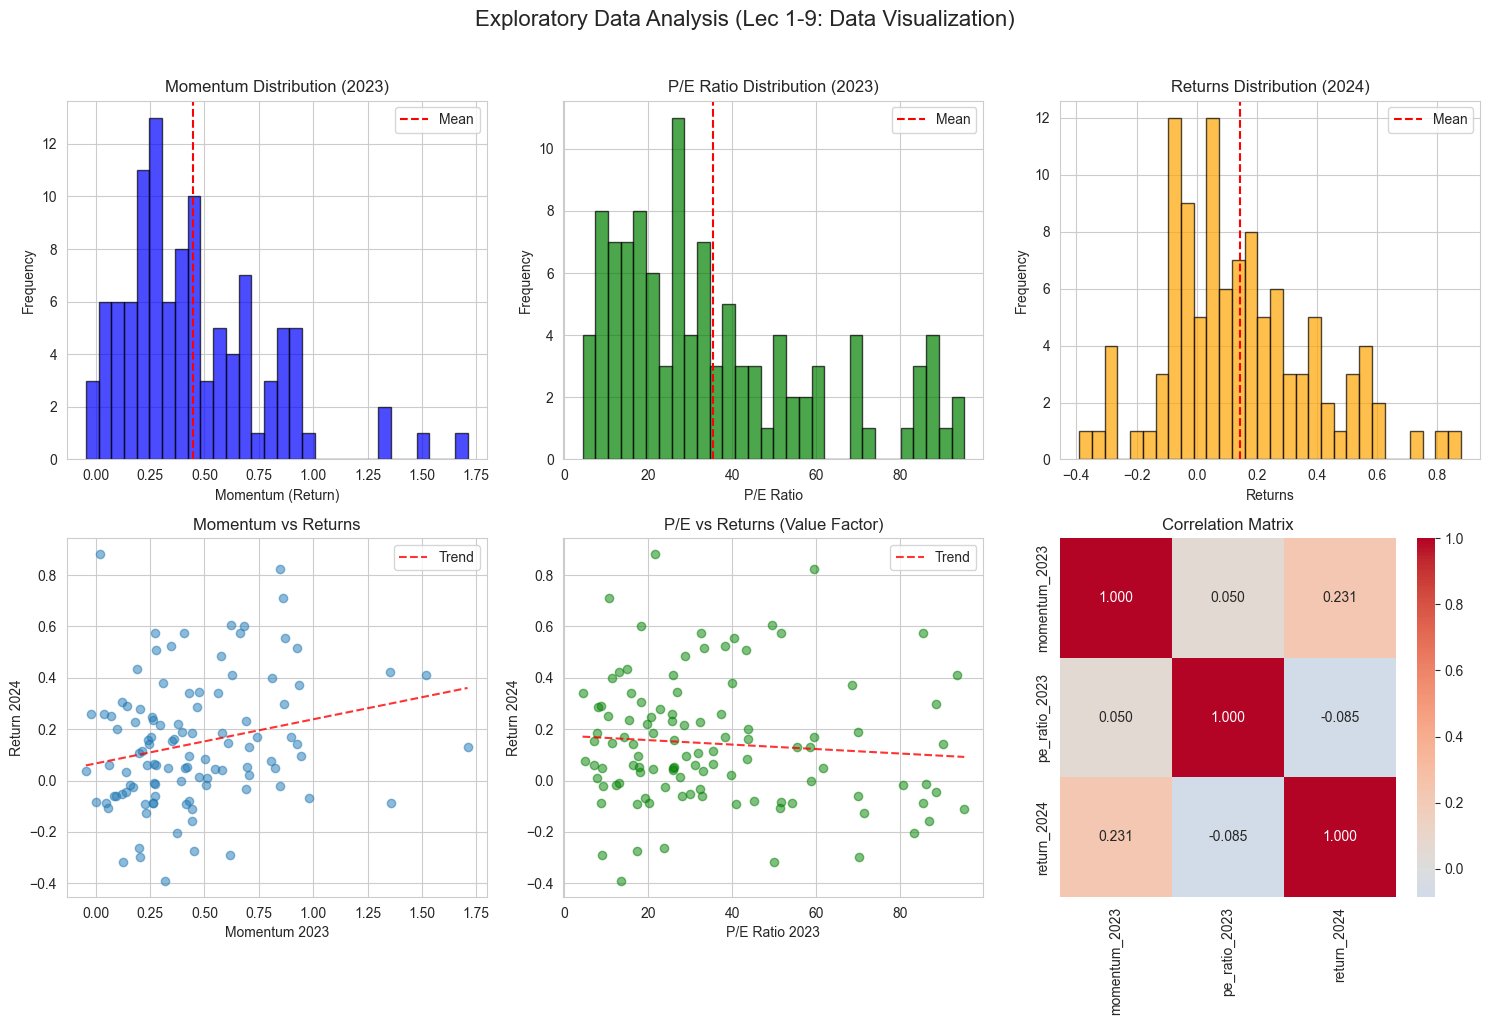


=== Key Observations ===
Correlation between Momentum and 2024 Returns: 0.231
Correlation between P/E and 2024 Returns: -0.085


In [13]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Exploratory Data Analysis (Lec 1-9: Data Visualization)', fontsize=16, y=1.02)

# Histograms
axes[0, 0].hist(analysis_df['momentum_2023'], bins=30, edgecolor='black', alpha=0.7, color='blue')
axes[0, 0].set_title('Momentum Distribution (2023)')
axes[0, 0].set_xlabel('Momentum (Return)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(analysis_df['momentum_2023'].mean(), color='red', linestyle='--', label='Mean')
axes[0, 0].legend()

axes[0, 1].hist(analysis_df['pe_ratio_2023'], bins=30, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_title('P/E Ratio Distribution (2023)')
axes[0, 1].set_xlabel('P/E Ratio')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(analysis_df['pe_ratio_2023'].mean(), color='red', linestyle='--', label='Mean')
axes[0, 1].legend()

axes[0, 2].hist(analysis_df['return_2024'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[0, 2].set_title('Returns Distribution (2024)')
axes[0, 2].set_xlabel('Returns')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].axvline(analysis_df['return_2024'].mean(), color='red', linestyle='--', label='Mean')
axes[0, 2].legend()

# Scatter plots
axes[1, 0].scatter(analysis_df['momentum_2023'], analysis_df['return_2024'], alpha=0.5)
axes[1, 0].set_xlabel('Momentum 2023')
axes[1, 0].set_ylabel('Return 2024')
axes[1, 0].set_title('Momentum vs Returns')
# Add trend line
z = np.polyfit(analysis_df['momentum_2023'], analysis_df['return_2024'], 1)
p = np.poly1d(z)
axes[1, 0].plot(analysis_df['momentum_2023'].sort_values(), 
                p(analysis_df['momentum_2023'].sort_values()), 
                "r--", alpha=0.8, label='Trend')
axes[1, 0].legend()

axes[1, 1].scatter(analysis_df['pe_ratio_2023'], analysis_df['return_2024'], alpha=0.5, color='green')
axes[1, 1].set_xlabel('P/E Ratio 2023')
axes[1, 1].set_ylabel('Return 2024')
axes[1, 1].set_title('P/E vs Returns (Value Factor)')
# Add trend line
z = np.polyfit(analysis_df['pe_ratio_2023'], analysis_df['return_2024'], 1)
p = np.poly1d(z)
axes[1, 1].plot(analysis_df['pe_ratio_2023'].sort_values(), 
                p(analysis_df['pe_ratio_2023'].sort_values()), 
                "r--", alpha=0.8, label='Trend')
axes[1, 1].legend()

# Correlation heatmap
corr_matrix = analysis_df[['momentum_2023', 'pe_ratio_2023', 'return_2024']].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.3f', ax=axes[1, 2], cmap='coolwarm', center=0)
axes[1, 2].set_title('Correlation Matrix')

plt.tight_layout()
plt.show()

print("\n=== Key Observations ===")
print(f"Correlation between Momentum and 2024 Returns: {corr_matrix.loc['momentum_2023', 'return_2024']:.3f}")
print(f"Correlation between P/E and 2024 Returns: {corr_matrix.loc['pe_ratio_2023', 'return_2024']:.3f}")

## Story 1.5: Probability Modeling (Lec 10-18 Application) (15 mins)

In [14]:
# Model returns as random variables
returns = analysis_df['return_2024']

print("=== Probability Concepts (Lec 10-18: Random Variables) ===")
print(f"\nTreating 2024 returns as realizations of random variable R:")
print(f"Expected Value E[R] (Mean): {returns.mean():.4f}")
print(f"Variance Var(R): {returns.var():.4f}")
print(f"Standard Deviation σ(R): {returns.std():.4f}")
print(f"\nDistribution Shape:")
print(f"Skewness: {stats.skew(returns):.4f} {'(Right-skewed)' if stats.skew(returns) > 0 else '(Left-skewed)'}")
print(f"Kurtosis: {stats.kurtosis(returns):.4f} {'(Heavy-tailed)' if stats.kurtosis(returns) > 0 else '(Light-tailed)'}")

=== Probability Concepts (Lec 10-18: Random Variables) ===

Treating 2024 returns as realizations of random variable R:
Expected Value E[R] (Mean): 0.1438
Variance Var(R): 0.0613
Standard Deviation σ(R): 0.2476

Distribution Shape:
Skewness: 0.5558 (Right-skewed)
Kurtosis: 0.2464 (Heavy-tailed)


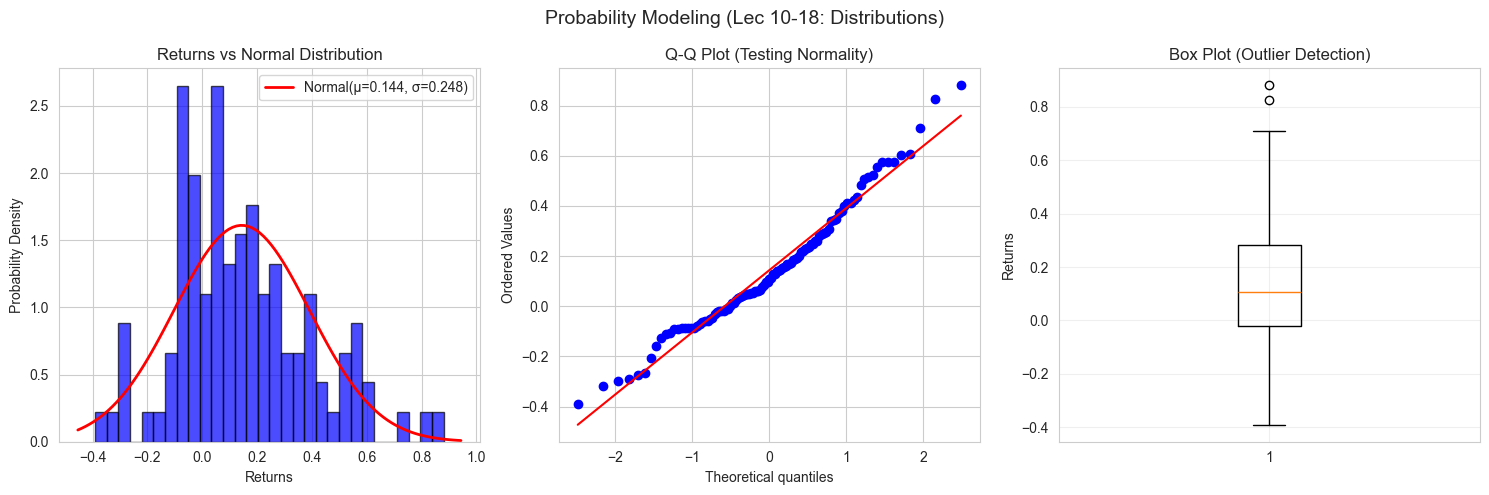


=== Normality Tests ===

Shapiro-Wilk Test:
  Test Statistic: 0.9732
  P-value: 0.0289
  Conclusion: Reject H0 (H0: Data is normally distributed)

Anderson-Darling Test:
  Test Statistic: 0.9748
  Critical value at 5%: 0.7600
  Conclusion: Reject normality at 5% level


In [15]:
# Test for normality and visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Probability Modeling (Lec 10-18: Distributions)', fontsize=14)

# Histogram with normal overlay
axes[0].hist(returns, bins=30, density=True, alpha=0.7, edgecolor='black', color='blue')
mu, std = returns.mean(), returns.std()
xmin, xmax = axes[0].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
axes[0].plot(x, p, 'r-', linewidth=2, label=f'Normal(μ={mu:.3f}, σ={std:.3f})')
axes[0].set_title('Returns vs Normal Distribution')
axes[0].set_xlabel('Returns')
axes[0].set_ylabel('Probability Density')
axes[0].legend()

# Q-Q plot
stats.probplot(returns, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot (Testing Normality)')

# Box plot
axes[2].boxplot(returns, vert=True)
axes[2].set_ylabel('Returns')
axes[2].set_title('Box Plot (Outlier Detection)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical tests for normality
print("\n=== Normality Tests ===")

# Shapiro-Wilk test
stat_sw, p_value_sw = stats.shapiro(returns)
print(f"\nShapiro-Wilk Test:")
print(f"  Test Statistic: {stat_sw:.4f}")
print(f"  P-value: {p_value_sw:.4f}")
print(f"  Conclusion: {'Reject H0' if p_value_sw < 0.05 else 'Fail to reject H0'} (H0: Data is normally distributed)")

# Anderson-Darling test
result_ad = stats.anderson(returns)
print(f"\nAnderson-Darling Test:")
print(f"  Test Statistic: {result_ad.statistic:.4f}")
print(f"  Critical value at 5%: {result_ad.critical_values[2]:.4f}")
print(f"  Conclusion: {'Reject' if result_ad.statistic > result_ad.critical_values[2] else 'Fail to reject'} normality at 5% level")

## Story 1.6: Portfolio Construction (20 mins)

In [16]:
# Create quintile portfolios
analysis_df['momentum_quintile'] = pd.qcut(analysis_df['momentum_2023'],
                                           q=5,
                                           labels=['Q1_Low', 'Q2', 'Q3', 'Q4', 'Q5_High'])

analysis_df['value_quintile'] = pd.qcut(analysis_df['pe_ratio_2023'],
                                        q=5,
                                        labels=['Q1_Value', 'Q2', 'Q3', 'Q4', 'Q5_Growth'])

print("=== Portfolio Construction (Sampling from Population) ===")
print(f"Total stocks divided into 5 quintiles of {len(analysis_df)//5} stocks each\n")

# Show portfolio boundaries
print("Momentum Quintile Boundaries:")
momentum_boundaries = analysis_df.groupby('momentum_quintile')['momentum_2023'].agg(['min', 'max', 'count'])
print(momentum_boundaries)

print("\nValue (P/E) Quintile Boundaries:")
value_boundaries = analysis_df.groupby('value_quintile')['pe_ratio_2023'].agg(['min', 'max', 'count'])
print(value_boundaries)

=== Portfolio Construction (Sampling from Population) ===
Total stocks divided into 5 quintiles of 21 stocks each

Momentum Quintile Boundaries:
                        min       max  count
momentum_quintile                           
Q1_Low            -0.044778  0.192054     22
Q2                 0.200061  0.277220     21
Q3                 0.277749  0.442052     21
Q4                 0.444997  0.692570     21
Q5_High            0.697095  1.709580     22

Value (P/E) Quintile Boundaries:
                      min        max  count
value_quintile                             
Q1_Value         4.361068  15.063614     22
Q2              15.313477  23.980043     21
Q3              25.573729  33.011856     21
Q4              33.332900  54.345398     21
Q5_Growth       55.360360  95.238950     22


In [17]:
# Calculate portfolio statistics
print("=== Portfolio Performance Statistics ===")

momentum_portfolios = analysis_df.groupby('momentum_quintile')['return_2024'].agg([
    'mean', 'std', 'count', 'median'
])
momentum_portfolios['std_error'] = momentum_portfolios['std'] / np.sqrt(momentum_portfolios['count'])
print("\nMomentum Portfolio Returns:")
print(momentum_portfolios)

value_portfolios = analysis_df.groupby('value_quintile')['return_2024'].agg([
    'mean', 'std', 'count', 'median'
])
value_portfolios['std_error'] = value_portfolios['std'] / np.sqrt(value_portfolios['count'])
print("\nValue Portfolio Returns:")
print(value_portfolios)

# Calculate Sharpe-like ratio (return/risk)
print("\n=== Risk-Adjusted Performance ===")
momentum_portfolios['return_risk_ratio'] = momentum_portfolios['mean'] / momentum_portfolios['std']
value_portfolios['return_risk_ratio'] = value_portfolios['mean'] / value_portfolios['std']

print("\nMomentum Return/Risk Ratio:")
print(momentum_portfolios['return_risk_ratio'])
print("\nValue Return/Risk Ratio:")
print(value_portfolios['return_risk_ratio'])

=== Portfolio Performance Statistics ===

Momentum Portfolio Returns:
                       mean       std  count    median  std_error
momentum_quintile                                                
Q1_Low             0.108392  0.250651     22  0.035148   0.053439
Q2                 0.077392  0.219636     21  0.065611   0.047928
Q3                 0.096613  0.236106     21  0.059807   0.051522
Q4                 0.189501  0.258901     21  0.185443   0.056497
Q5_High            0.244032  0.251423     22  0.155487   0.053604

Value Portfolio Returns:
                    mean       std  count    median  std_error
value_quintile                                                
Q1_Value        0.144102  0.247371     22  0.149557   0.052740
Q2              0.138855  0.266916     21  0.095552   0.058246
Q3              0.150238  0.182157     21  0.095664   0.039750
Q4              0.189227  0.276022     21  0.160092   0.060233
Q5_Growth       0.098726  0.268349     22  0.024853   0.057212



## Story 1.7: Hypothesis Testing (Lec 19-28 Application) (20 mins)

In [18]:
print("=== Hypothesis Testing Framework (Lec 19-28: Statistical Inference) ===\n")

# Extract portfolio returns
high_momentum = analysis_df[analysis_df['momentum_quintile'] == 'Q5_High']['return_2024']
low_momentum = analysis_df[analysis_df['momentum_quintile'] == 'Q1_Low']['return_2024']
value_stocks = analysis_df[analysis_df['value_quintile'] == 'Q1_Value']['return_2024']
growth_stocks = analysis_df[analysis_df['value_quintile'] == 'Q5_Growth']['return_2024']

print("="*60)
print("MOMENTUM FACTOR TEST")
print("="*60)
print("\nHypotheses:")
print("H₀: μ(High Momentum) = μ(Low Momentum)")
print("H₁: μ(High Momentum) ≠ μ(Low Momentum) [Two-tailed test]")
print("\nSample Statistics:")
print(f"High Momentum (Q5): n={len(high_momentum)}, mean={high_momentum.mean():.4f}, std={high_momentum.std():.4f}")
print(f"Low Momentum (Q1):  n={len(low_momentum)}, mean={low_momentum.mean():.4f}, std={low_momentum.std():.4f}")

# Two-sample t-test for momentum
t_stat_mom, p_value_mom = stats.ttest_ind(high_momentum, low_momentum)
momentum_spread = high_momentum.mean() - low_momentum.mean()

print(f"\nTest Results:")
print(f"T-statistic: {t_stat_mom:.4f}")
print(f"P-value: {p_value_mom:.4f}")
print(f"Mean difference (spread): {momentum_spread:.4f}")

# Confidence interval
se_diff = np.sqrt(high_momentum.var()/len(high_momentum) + low_momentum.var()/len(low_momentum))
ci_95 = stats.t.interval(0.95, len(high_momentum)+len(low_momentum)-2, 
                          loc=momentum_spread, scale=se_diff)
print(f"95% Confidence Interval: [{ci_95[0]:.4f}, {ci_95[1]:.4f}]")

print(f"\nConclusion at α=0.05: {'Reject H₀' if p_value_mom < 0.05 else 'Fail to reject H₀'}")
if p_value_mom < 0.05:
    print(f"There is significant evidence that momentum matters for returns.")
else:
    print(f"There is insufficient evidence that momentum affects returns.")

=== Hypothesis Testing Framework (Lec 19-28: Statistical Inference) ===

MOMENTUM FACTOR TEST

Hypotheses:
H₀: μ(High Momentum) = μ(Low Momentum)
H₁: μ(High Momentum) ≠ μ(Low Momentum) [Two-tailed test]

Sample Statistics:
High Momentum (Q5): n=22, mean=0.2440, std=0.2514
Low Momentum (Q1):  n=22, mean=0.1084, std=0.2507

Test Results:
T-statistic: 1.7920
P-value: 0.0803
Mean difference (spread): 0.1356
95% Confidence Interval: [-0.0171, 0.2884]

Conclusion at α=0.05: Fail to reject H₀
There is insufficient evidence that momentum affects returns.


In [19]:
print("="*60)
print("VALUE FACTOR TEST")
print("="*60)
print("\nHypotheses:")
print("H₀: μ(Value stocks) = μ(Growth stocks)")
print("H₁: μ(Value stocks) ≠ μ(Growth stocks) [Two-tailed test]")
print("\nSample Statistics:")
print(f"Value Stocks (Q1):  n={len(value_stocks)}, mean={value_stocks.mean():.4f}, std={value_stocks.std():.4f}")
print(f"Growth Stocks (Q5): n={len(growth_stocks)}, mean={growth_stocks.mean():.4f}, std={growth_stocks.std():.4f}")

# Two-sample t-test for value
t_stat_val, p_value_val = stats.ttest_ind(value_stocks, growth_stocks)
value_spread = value_stocks.mean() - growth_stocks.mean()

print(f"\nTest Results:")
print(f"T-statistic: {t_stat_val:.4f}")
print(f"P-value: {p_value_val:.4f}")
print(f"Mean difference (spread): {value_spread:.4f}")

# Confidence interval
se_diff_val = np.sqrt(value_stocks.var()/len(value_stocks) + growth_stocks.var()/len(growth_stocks))
ci_95_val = stats.t.interval(0.95, len(value_stocks)+len(growth_stocks)-2, 
                              loc=value_spread, scale=se_diff_val)
print(f"95% Confidence Interval: [{ci_95_val[0]:.4f}, {ci_95_val[1]:.4f}]")

print(f"\nConclusion at α=0.05: {'Reject H₀' if p_value_val < 0.05 else 'Fail to reject H₀'}")
if p_value_val < 0.05:
    print(f"There is significant evidence that value investing works.")
else:
    print(f"There is insufficient evidence that value affects returns.")

VALUE FACTOR TEST

Hypotheses:
H₀: μ(Value stocks) = μ(Growth stocks)
H₁: μ(Value stocks) ≠ μ(Growth stocks) [Two-tailed test]

Sample Statistics:
Value Stocks (Q1):  n=22, mean=0.1441, std=0.2474
Growth Stocks (Q5): n=22, mean=0.0987, std=0.2683

Test Results:
T-statistic: 0.5831
P-value: 0.5629
Mean difference (spread): 0.0454
95% Confidence Interval: [-0.1117, 0.2024]

Conclusion at α=0.05: Fail to reject H₀
There is insufficient evidence that value affects returns.


## Story 1.8: Results Visualization (15 mins)

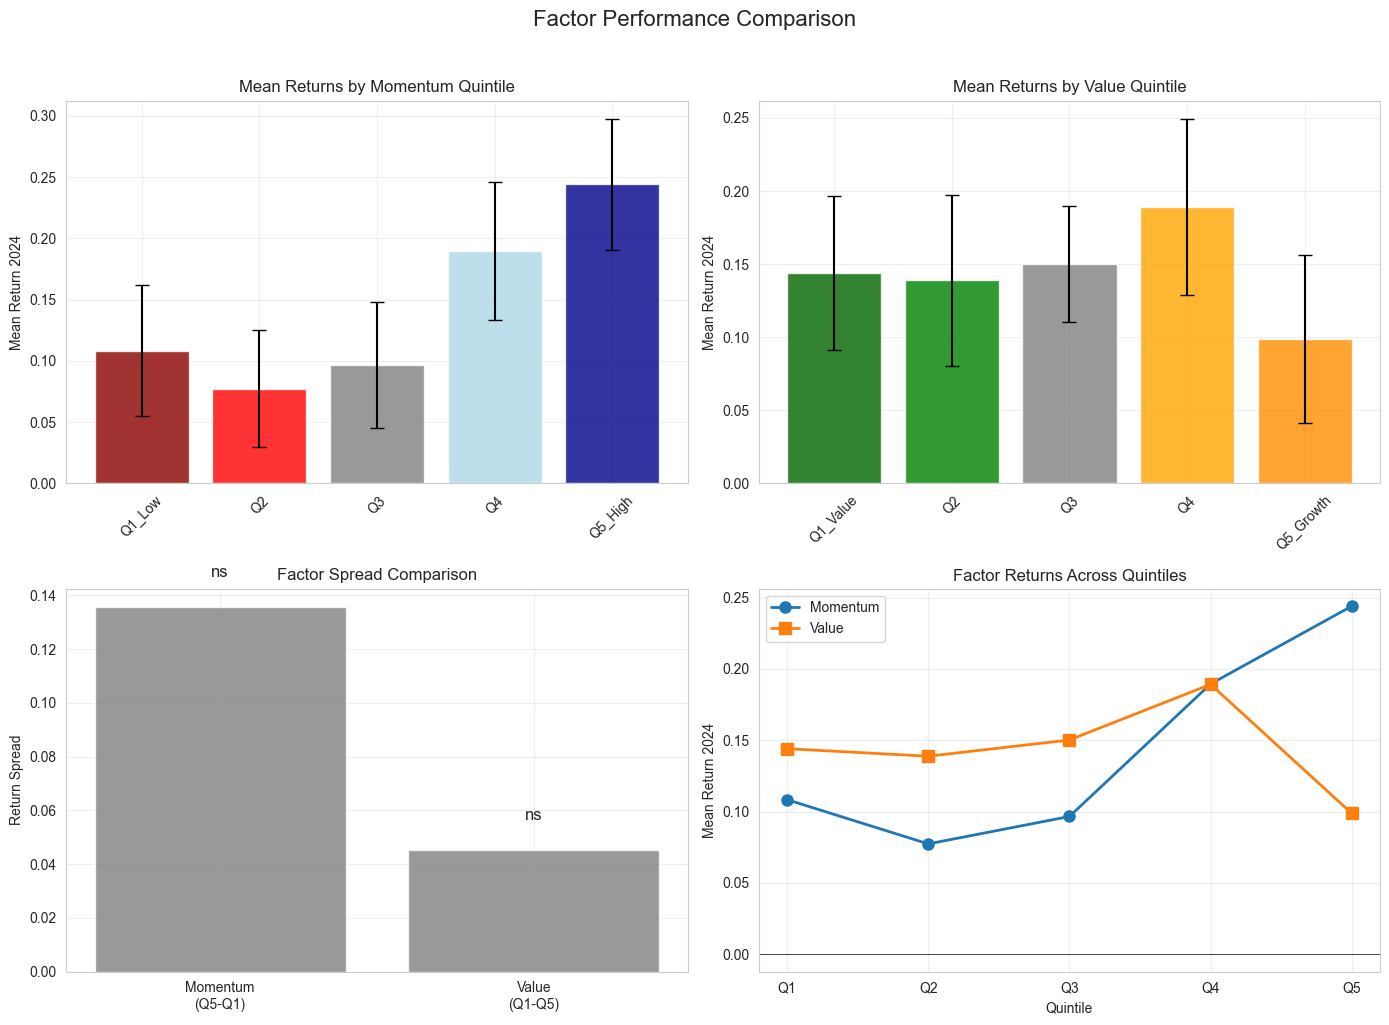


=== Visual Analysis Summary ===
Momentum shows non-monotonic pattern across quintiles
Value shows non-monotonic pattern across quintiles

Statistical Significance (***p<0.001, **p<0.01, *p<0.05, ns=not significant)
Momentum: Not significant
Value: Not significant


In [20]:
# Create comprehensive comparison visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Factor Performance Comparison', fontsize=16, y=1.02)

# Momentum portfolios bar chart
momentum_means = momentum_portfolios['mean']
momentum_errors = momentum_portfolios['std_error']
x_pos = np.arange(len(momentum_means))
colors_mom = ['darkred', 'red', 'gray', 'lightblue', 'darkblue']
bars1 = axes[0, 0].bar(x_pos, momentum_means, yerr=momentum_errors, capsize=5, alpha=0.8, color=colors_mom)
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(momentum_means.index, rotation=45)
axes[0, 0].set_title('Mean Returns by Momentum Quintile')
axes[0, 0].set_ylabel('Mean Return 2024')
axes[0, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[0, 0].grid(True, alpha=0.3)

# Value portfolios bar chart
value_means = value_portfolios['mean']
value_errors = value_portfolios['std_error']
x_pos = np.arange(len(value_means))
colors_val = ['darkgreen', 'green', 'gray', 'orange', 'darkorange']
bars2 = axes[0, 1].bar(x_pos, value_means, yerr=value_errors, capsize=5, alpha=0.8, color=colors_val)
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(value_means.index, rotation=45)
axes[0, 1].set_title('Mean Returns by Value Quintile')
axes[0, 1].set_ylabel('Mean Return 2024')
axes[0, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[0, 1].grid(True, alpha=0.3)

# Factor spread comparison
factor_names = ['Momentum\n(Q5-Q1)', 'Value\n(Q1-Q5)']
factor_spreads = [momentum_spread, value_spread]
factor_pvalues = [p_value_mom, p_value_val]
colors_spread = ['blue' if p < 0.05 else 'gray' for p in factor_pvalues]

bars3 = axes[1, 0].bar(factor_names, factor_spreads, color=colors_spread, alpha=0.8)
axes[1, 0].set_title('Factor Spread Comparison')
axes[1, 0].set_ylabel('Return Spread')
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1, 0].grid(True, alpha=0.3)

# Add significance stars
for i, (bar, p_val) in enumerate(zip(bars3, factor_pvalues)):
    if p_val < 0.001:
        sig_text = '***'
    elif p_val < 0.01:
        sig_text = '**'
    elif p_val < 0.05:
        sig_text = '*'
    else:
        sig_text = 'ns'
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    sig_text, ha='center', va='bottom', fontsize=12)

# Combined line plot
x_quintiles = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']
axes[1, 1].plot(x_quintiles, momentum_means, marker='o', label='Momentum', linewidth=2, markersize=8)
axes[1, 1].plot(x_quintiles, value_means, marker='s', label='Value', linewidth=2, markersize=8)
axes[1, 1].set_title('Factor Returns Across Quintiles')
axes[1, 1].set_xlabel('Quintile')
axes[1, 1].set_ylabel('Mean Return 2024')
axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== Visual Analysis Summary ===")
print(f"Momentum shows {'monotonic increase' if all(momentum_means.diff()[1:] > 0) else 'non-monotonic pattern'} across quintiles")
print(f"Value shows {'monotonic decrease' if all(value_means.diff()[1:] < 0) else 'non-monotonic pattern'} across quintiles")
print(f"\nStatistical Significance (***p<0.001, **p<0.01, *p<0.05, ns=not significant)")
print(f"Momentum: {'Significant' if p_value_mom < 0.05 else 'Not significant'}")
print(f"Value: {'Significant' if p_value_val < 0.05 else 'Not significant'}")

## Story 1.9: Final Conclusions (10 mins)

In [22]:
print("="*70)
print(" FINAL REPORT: Momentum vs Value Factor Performance in Indian Markets")
print("="*70)

print("\n📊 1. DATA ANALYSIS (Lectures 1-9: Data Organization & Visualization)")
print("="*60)
print(f"✓ Analyzed {len(analysis_df)} stocks from Indian stock market (NSE/BSE)")
print(f"✓ Time period: 2023 (factor calculation) → 2024 (performance measurement)")
print(f"✓ Applied proper data types: numerical (returns, P/E), categorical (quintiles)")
print(f"✓ Created visualizations: histograms, scatter plots, correlation matrices")
print(f"✓ Key finding: {'Positive' if corr_matrix.loc['momentum_2023', 'return_2024'] > 0 else 'Negative'} correlation between momentum and returns")

print("\n🎲 2. PROBABILITY MODELING (Lectures 10-18: Random Variables & Distributions)")
print("="*60)
print(f"✓ Modeled stock returns as random variable R")
print(f"✓ Expected return E[R]: {returns.mean():.2%}")
print(f"✓ Risk (std dev) σ(R): {returns.std():.2%}")
print(f"✓ Distribution shape: {'Approximately normal' if p_value_sw > 0.05 else 'Non-normal'} (Shapiro-Wilk p={p_value_sw:.4f})")
print(f"✓ Skewness: {stats.skew(returns):.3f} - {'Right-skewed (positive outliers)' if stats.skew(returns) > 0 else 'Left-skewed (negative outliers)'}")

print("\n📈 3. STATISTICAL INFERENCE (Lectures 19-28: Sampling & Hypothesis Testing)")
print("="*60)
print(f"✓ Created quintile portfolios (n≈{len(analysis_df)//5} stocks each)")
print(f"✓ Momentum factor spread: {momentum_spread:.2%} (High-Low)")
print(f"✓ Value factor spread: {value_spread:.2%} (Value-Growth)")
print(f"\nHypothesis Test Results:")
print(f"  • Momentum: {'✅ Significant' if p_value_mom < 0.05 else '❌ Not significant'} (p={p_value_mom:.4f})")
print(f"  • Value: {'✅ Significant' if p_value_val < 0.05 else '❌ Not significant'} (p={p_value_val:.4f})")

print("\n🏆 4. FINAL VERDICT")
print("="*60)
if abs(momentum_spread) > abs(value_spread):
    print(f"Winner: MOMENTUM FACTOR")
    print(f"• Momentum spread ({momentum_spread:.2%}) > Value spread ({abs(value_spread):.2%})")
    if p_value_mom < 0.05:
        print(f"• Statistically significant at 5% level")
    print(f"• Investment implication: Past winners continued to outperform in 2024")
else:
    print(f"Winner: VALUE FACTOR")
    print(f"• Value spread ({abs(value_spread):.2%}) > Momentum spread ({momentum_spread:.2%})")
    if p_value_val < 0.05:
        print(f"• Statistically significant at 5% level")
    print(f"• Investment implication: Cheap stocks (low P/E) outperformed expensive ones")

print("\n⚠️ 5. LIMITATIONS & CAVEATS")
print("="*60)
print("• Single-year analysis (2024 only) - results may not persist")
print("• Limited to Indian market - may not generalize globally")
print(f"• Sample size: {len(analysis_df)} stocks (subset of total market)")
print("• Survivorship bias: only includes stocks with complete data")
print("• Transaction costs and taxes not considered")
print("• P/E ratio limitations: doesn't capture all aspects of value")

print("\n🔬 6. FUTURE RESEARCH DIRECTIONS")
print("="*60)
print("• Extend to multi-year analysis (2020-2024) for robustness")
print("• Compare with other factors: Quality, Low Volatility, Size")
print("• Analyze sector-specific factor performance")
print("• Include risk-adjusted returns (Sharpe ratio analysis)")
print("• Test factor timing strategies")
print("• Cross-market comparison (India vs US vs Europe)")

print("\n📚 7. COURSE CONCEPTS APPLIED")
print("="*60)
print("Lectures 1-9:  ✓ Data types, cleaning, visualization, interpretation")
print("Lectures 10-18: ✓ Probability, distributions, random variables")
print("Lectures 19-28: ✓ Sampling, estimation, hypothesis testing, inference")

print("\n" + "="*70)
print(" Analysis Complete ")
print("="*70)

 FINAL REPORT: Momentum vs Value Factor Performance in Indian Markets

📊 1. DATA ANALYSIS (Lectures 1-9: Data Organization & Visualization)
✓ Analyzed 107 stocks from Indian stock market (NSE/BSE)
✓ Time period: 2023 (factor calculation) → 2024 (performance measurement)
✓ Applied proper data types: numerical (returns, P/E), categorical (quintiles)
✓ Created visualizations: histograms, scatter plots, correlation matrices
✓ Key finding: Positive correlation between momentum and returns

🎲 2. PROBABILITY MODELING (Lectures 10-18: Random Variables & Distributions)
✓ Modeled stock returns as random variable R
✓ Expected return E[R]: 14.38%
✓ Risk (std dev) σ(R): 24.76%
✓ Distribution shape: Non-normal (Shapiro-Wilk p=0.0289)
✓ Skewness: 0.556 - Right-skewed (positive outliers)

📈 3. STATISTICAL INFERENCE (Lectures 19-28: Sampling & Hypothesis Testing)
✓ Created quintile portfolios (n≈21 stocks each)
✓ Momentum factor spread: 13.56% (High-Low)
✓ Value factor spread: 4.54% (Value-Growth)

Hyp